In [26]:
#import natutal 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
#import package needed
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import ast 
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#word cloud 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy

ModuleNotFoundError: No module named 'seaborn'

In [3]:
#load dataframe
tws_df = pd.read_csv('/home/zhoulita/scratch/covid_data_unprocessed/dataFrame/tweet_df_loc_total.csv',low_memory=False,lineterminator='\n')

def get_week_index(df):
    return int((df['day_index']-1)/7)
tws_df['week_index']= tws_df.apply(get_week_index,axis = 1)
#remove unnecessary column
tws_df.drop(['lang', 'referenced_tweets','author_id', 'source', 'possibly_sensitive', 'public_metrics','entities', 'context_annotations', 'in_reply_to_user_id', 'attachments'], axis=1, inplace=True)
tws_df.drop(['Unnamed: 0', 'Unnamed: 0.1','geo_x', 'id_y', 'withheld'], axis=1, inplace=True)

In [4]:
#load the us places with the state code
us_pls_df = pd.read_csv("/home/zhoulita/scratch/covid_19_tweets/us_places.csv")
us_pls_df.drop(['Unnamed: 0', 'full_name','place_type', 'country_code', 'country','geo','name','Lontitude','Latitude'], axis=1, inplace=True)

In [5]:
total_df = pd.merge(tws_df,us_pls_df,how = 'inner',left_on = 'geo_id',right_on = 'id')
total_df.drop(['place_type', 'country','place_type', 'Lontitude', 'geo_y','Latitude','id'], axis=1, inplace=True)

In [7]:
#text cleaning
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



#define a function to clean the text
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)#remove the @
    text = re.sub(r'#','',text) #remove the #
    text = re.sub(r'RT[\s]+','',text) #remove retweet
    text = re.sub(r'https?:\/\/\S+','',text) #remove http 
    text =  re.sub('\n','',text)
    text = re.sub('\S*@\S*\s?', '', text)#remove email
    text = re.sub('\s+', ' ', text)
    text = remove_emoji(text)
    return text

total_df['processed_text'] = total_df['text'].apply(clean_text)


In [8]:
#use regex to clean and filter out the useful info from tweets related to family 
regex_election = re.compile(r'(?i)Trump|Biden|Election|democratic|republican|party|President|campaign|elector|candidate') 
regex_mask = re.compile(r'(?i)mask|Mask')

def mask_related_text(text):
    if regex_mask.search(text):
        return True
    return False

def election_related_text(text):
    if regex_election.search(text):
        return True
    return False

total_df['election_related'] = total_df['processed_text'].apply(election_related_text)
total_df['mask_related'] = total_df['processed_text'].apply(mask_related_text)
total_df = total_df[(total_df["mask_related"]==True)&(total_df["election_related"]==False)]

In [9]:
def process_to_phrase(string):
    return gensim.utils.simple_preprocess(str(string), deacc=True)

total_df['processed_text_phrase'] = total_df['processed_text'].apply(process_to_phrase)

/tmp/ipykernel_2434/3417608527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['processed_text_phrase'] = total_df['processed_text'].apply(process_to_phrase)


In [10]:
data = total_df['processed_text_phrase'].values.tolist()

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [12]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemm`atization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data)  # processed Text Data!

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# use the for loop to find out the best number of topics to use for the highest coherence number
topic_num_coherence_df = pd.DataFrame()
for i in range(3,16):
    topic_num = i
    print("Number of Topics:",topic_num)
    temp_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic_num, 
                                           update_every=1,
                                           random_state=50,
                                           passes=20,
                                           per_word_topics=True)
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=temp_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    #attach to the data frame
    topic_num_coherence_df = topic_num_coherence_df.append(pd.Series([int(i),coherence_lda]), ignore_index=True)
    
    print('Coherence Score: ', coherence_lda)

topic_num_coherence_df.columns = ['Topics_Num', 'Coherence_score']

Number of Topics: 3
Coherence Score:  0.3615074549461758
Number of Topics: 4
Coherence Score:  0.39629907552532784
Number of Topics: 5
Coherence Score:  0.39944694163352984
Number of Topics: 6
Coherence Score:  0.4246041189588994
Number of Topics: 7


In [20]:
topic_num = 8
lda_model_8 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic_num, 
                                           update_every=1,
                                           random_state=50,
                                           passes=20,
                                           per_word_topics=True)

In [21]:
#print out the topic words
pprint(lda_model_8.print_topics())

[(0,
  '0.146*"mask" + 0.116*"wear" + 0.039*"people" + 0.021*"covid" + '
  '0.011*"pandemic" + 0.010*"still" + 0.009*"work" + 0.008*"tell" + '
  '0.008*"time" + 0.007*"really"'),
 (1,
  '0.052*"covid" + 0.029*"amp" + 0.017*"people" + 0.012*"pandemic" + '
  '0.012*"die" + 0.011*"hospital" + 0.011*"family" + 0.010*"mask" + '
  '0.010*"life" + 0.010*"live"'),
 (2,
  '0.064*"mask" + 0.025*"covid" + 0.021*"amp" + 0.015*"mandate" + '
  '0.015*"school" + 0.015*"vaccine" + 0.011*"work" + 0.010*"state" + '
  '0.009*"student" + 0.009*"business"'),
 (3,
  '0.135*"wearamask" + 0.025*"covid" + 0.022*"maskup" + 0.019*"day" + '
  '0.016*"today" + 0.014*"vote" + 0.014*"washyourhand" + 0.013*"wearadamnmask" '
  '+ 0.010*"night" + 0.009*"happy"'),
 (4,
  '0.070*"covid" + 0.033*"case" + 0.025*"test" + 0.017*"week" + 0.017*"number" '
  '+ 0.016*"day" + 0.015*"death" + 0.014*"coronavirus" + 0.013*"florida" + '
  '0.013*"new"'),
 (5,
  '0.069*"mask" + 0.068*"face" + 0.033*"covid" + 0.018*"coronavirus" + '
 

In [25]:
#visualize the model
lda_display_8 = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, id2word, sort_topics=False, mds='mmds')
pyLDAvis.save_html(lda_display_8, "Sentiment_Analysis\mask_related_8_topics.html")
pyLDAvis.display(lda_display_8)

Creat the wordCloud

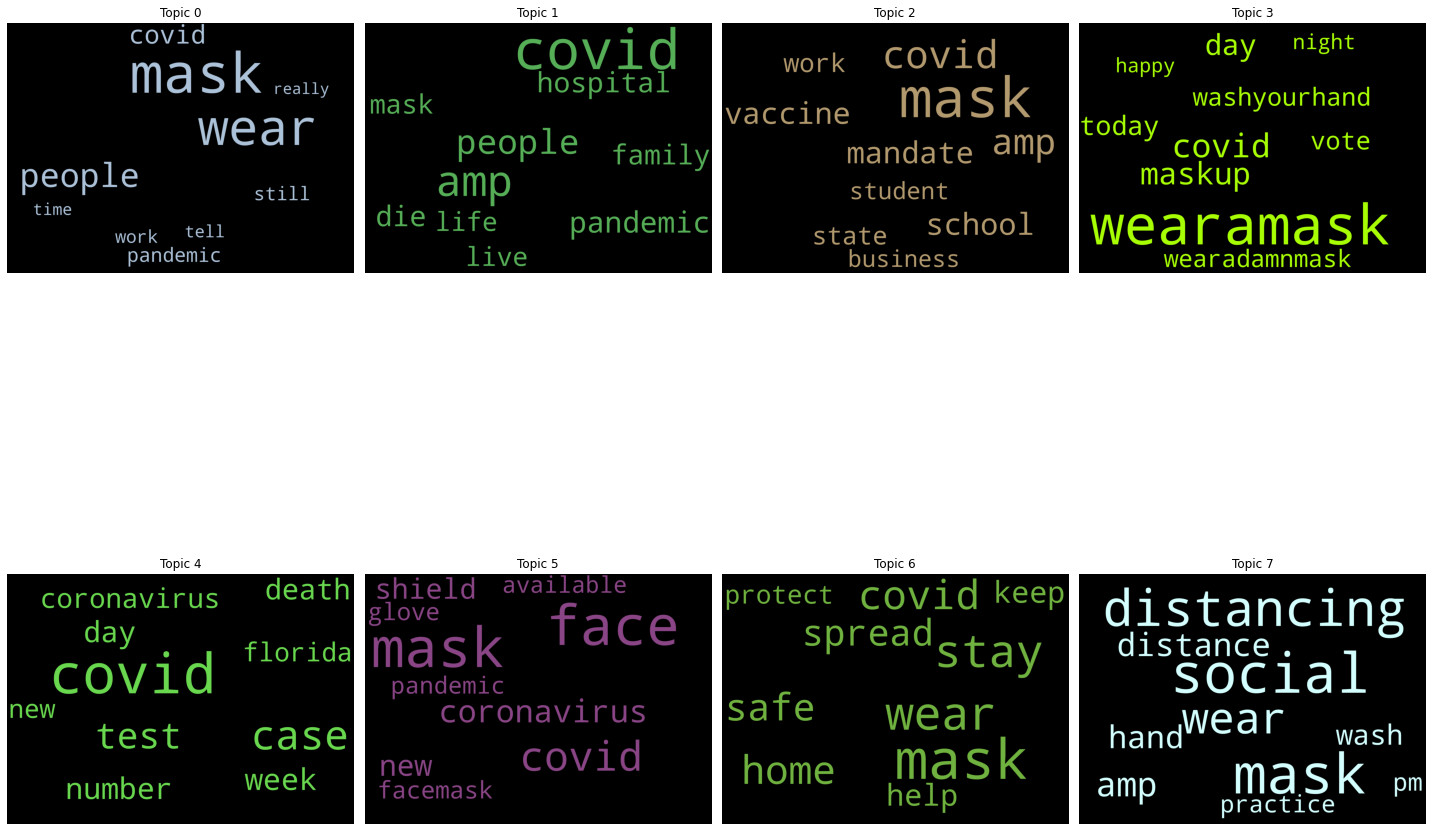

In [32]:
#get the colors
cols = [color for name, color in mcolors.XKCD_COLORS.items()] 

cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_8.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

The dominant words of each topic

In [35]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contribution', 'Keywords', 'Text']

In [36]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Contribution,Keywords,Text
0,0,5.0,0.6247,"mask, face, covid, coronavirus, new, shield, f...","[corona, outbreak, darth_vader, mask]"
1,1,3.0,0.3305,"wearamask, covid, maskup, day, today, vote, wa...","[father, china, stop, everyday, corona, virus,..."
2,2,0.0,0.7153,"mask, wear, people, covid, pandemic, still, wo...","[extreme, guy, drive, next, wear, gas, mask, d..."
3,3,0.0,0.7085,"mask, wear, people, covid, pandemic, still, wo...","[day, look, weird, wear, mask, feel, weird, we..."
4,4,5.0,0.6833,"mask, face, covid, coronavirus, new, shield, f...","[different, pattern, available, child, adult, ..."
...,...,...,...,...,...
242399,242399,0.0,0.5077,"mask, wear, people, covid, pandemic, still, wo...","[really, give, much, shit, rule, state, county..."
242400,242400,7.0,0.3617,"mask, social, distancing, wear, amp, distance,...","[remember, mask, still, require, campus, cente..."
242401,242401,2.0,0.3626,"mask, covid, amp, mandate, school, vaccine, wo...","[osunewsclass, work, photography, find, theme,..."
242402,242402,0.0,0.4035,"mask, wear, people, covid, pandemic, still, wo...","[west, lafayette, pay, less, store, surround, ..."


Establish the word count and the the weight of each word in each topic<br>
visualize the weigh and count of Each word in each of the topic 

/tmp/ipykernel_2434/3873409134.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/3873409134.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/3873409134.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/3873409134.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/3873409134.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word']

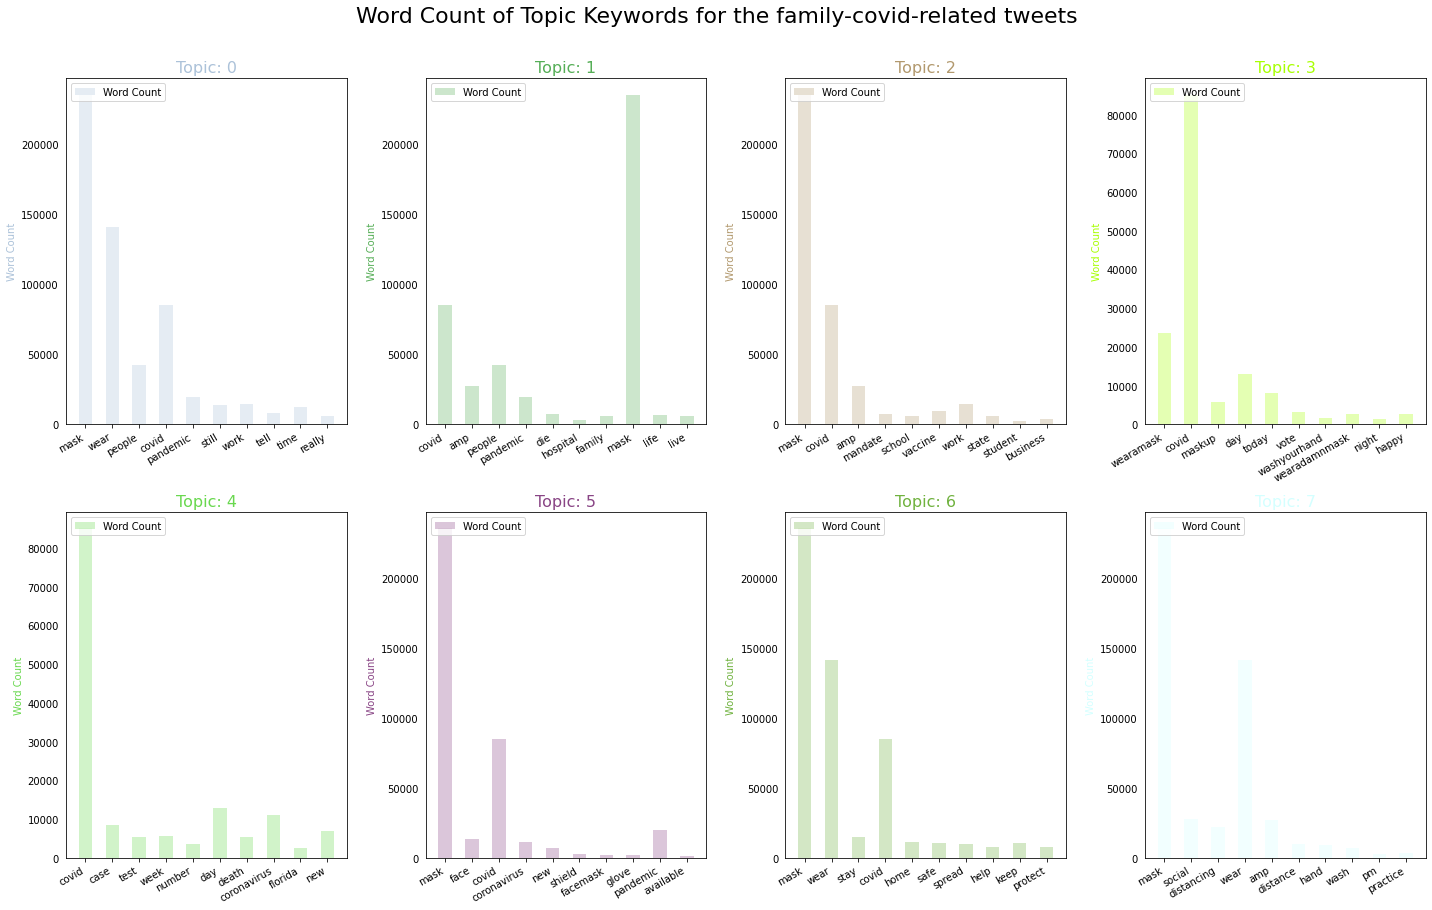

In [38]:
#the bar chart
from collections import Counter
topics = lda_model_8.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])


fig, axes = plt.subplots(2,4, figsize=(20,12), sharey=False )

cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
#     ax_twin = ax.twinx()
#     ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); #ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count of Topic Keywords for the family-covid-related tweets', fontsize=22, y=1.05)    
plt.show()

/tmp/ipykernel_2434/2055638600.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/2055638600.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/2055638600.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/2055638600.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_2434/2055638600.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word']

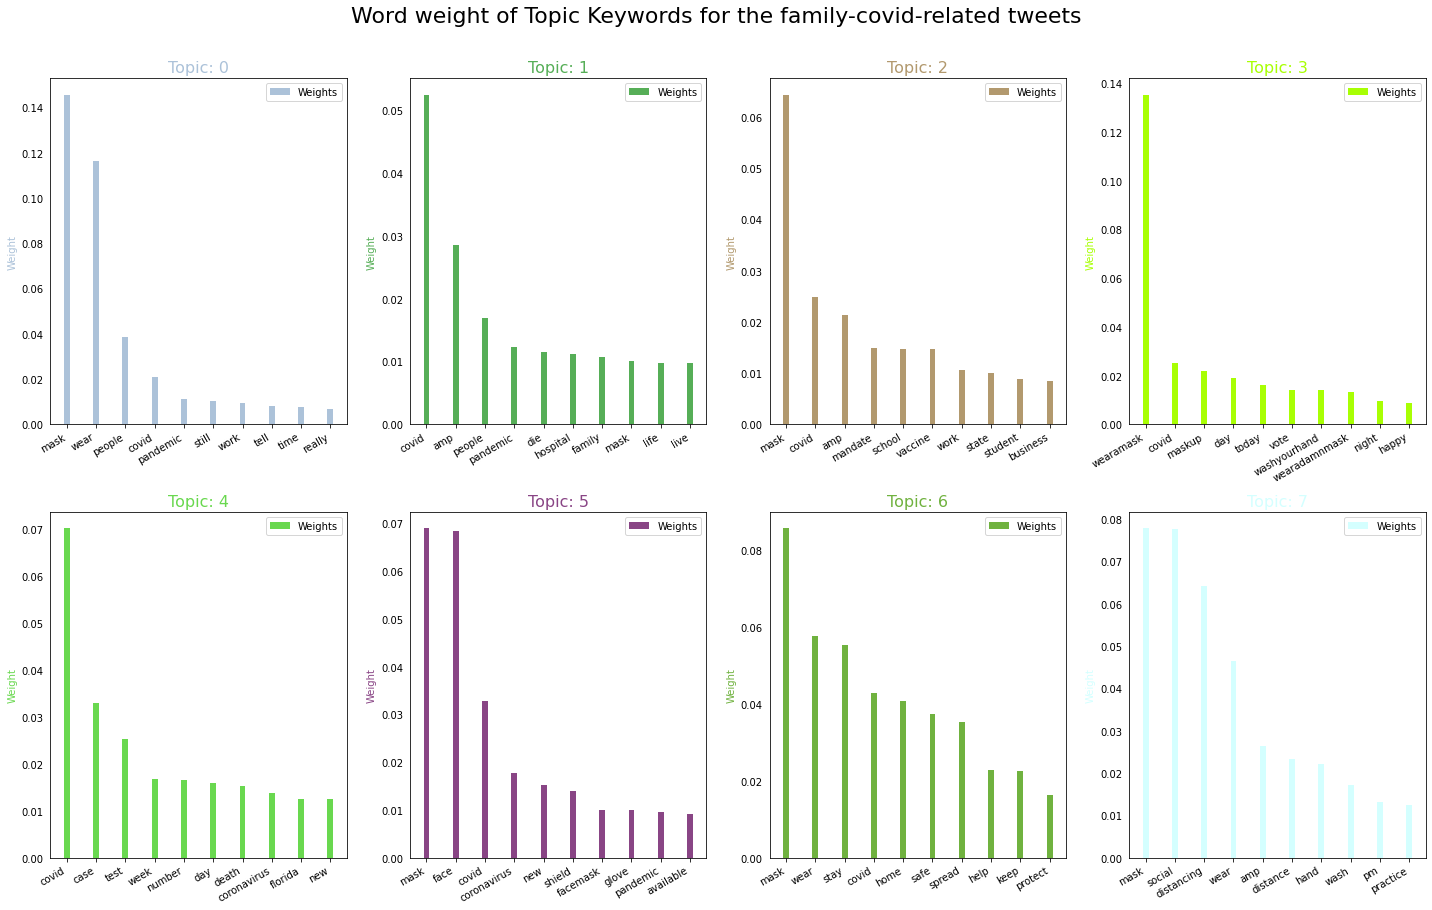

In [39]:
fig, axes = plt.subplots(2,4, figsize=(20,12), sharey=False )

cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Weight', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word weight of Topic Keywords for the family-covid-related tweets', fontsize=22, y=1.05)    
plt.show()